# ELAIS-N1 Selection Functions
## Depth maps and selection functions for ELAIS-N1

The simplest selection function available is the field MOC which specifies the area for which there is Herschel data. Each pristine catalogue also has a MOC defining the area for which that data is available.

The next stage is to provide mean flux standard deviations which act as a proxy for the catalogue's 5$\sigma$ depth

In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, join
import numpy as np
from pymoc import MOC
import healpy as hp
#import pandas as pd #Astropy has group_by function so apandas isn't required.
import seaborn as sns

from herschelhelp_internal.utils import inMoc, coords_to_hpidx

In [2]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))
ORDER = 10
#TODO write code to decide on appropriate order

field_moc = MOC(filename="../../dmu2/dmu2_field_coverages/ELAIS-N1_MOC.fits")
master_catalogue = Table.read("{}/master_catalogue_elais_n1_20170706.fits".format(OUT_DIR))

Plotting a histogram of magnitudes gives a quick idea of depth. 

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)


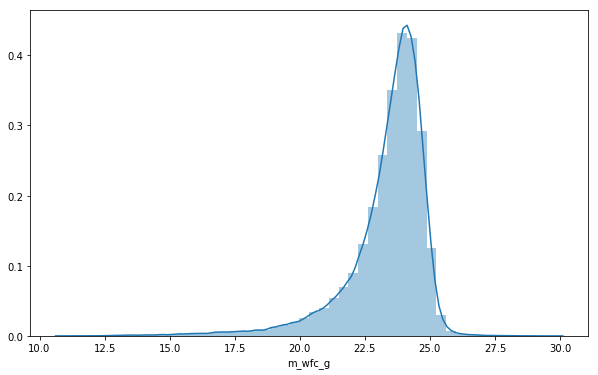

In [3]:
sns.distplot(master_catalogue['m_wfc_g'][(master_catalogue['m_wfc_g'] > 0) &  (master_catalogue['m_wfc_g'] < 90.)])

and for flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, oper)(other)
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:928: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, oper)(other)


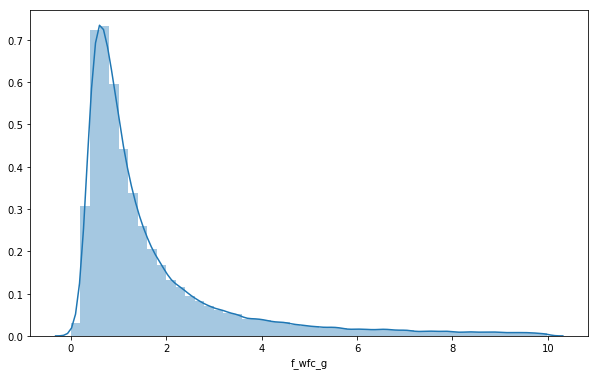

In [4]:
sns.distplot(master_catalogue['f_wfc_g'][(master_catalogue['f_wfc_g'] < 10.)  & (master_catalogue['f_wfc_g'] > 0)] )

## I - Group masterlist objects by healpix cell and calculate depths
We add a column to the masterlist catalogue for the target order healpix cell <i>per object</i>.

In [5]:
#Add a column to the catalogue with the order=ORDER hp_idx
master_catalogue.add_column(Column(data=coords_to_hpidx(master_catalogue['ra'],
                                                       master_catalogue['dec'],
                                                       ORDER), 
                                   name="hp_idx_O_{}".format(str(ORDER))
                                  )
                           )

In [7]:
# Convert catalogue to pandas and group by the order=ORDER pixel

group = master_catalogue.group_by(["hp_idx_O_{}".format(str(ORDER))])

In [11]:
f_wfc_g_p90 = group["hp_idx_O_{}".format(str(ORDER)), 'f_wfc_g'].groups.aggregate(lambda x: np.nanpercentile(x, 90.))
f_wfc_g_p90['f_wfc_g'].name = 'f_wfc_g_p90'
f_wfc_g_p90[:10].show_in_notebook()

idx,hp_idx_O_10,f_wfc_g_p90
0,2599293,28.1521141052
1,2599294,12.4450473785
2,2599295,18.4842218399
3,2599357,64.7755427837
4,2599358,784.577451229
5,2599359,9.03223676682
6,2599373,40.5134963989
7,2599374,5.3885846138
8,2599375,6.94386129379
9,2599377,7.3851975441


In [12]:
ferr_wfc_g_mean = group["hp_idx_O_{}".format(str(ORDER)), 'ferr_wfc_g'].groups.aggregate(np.nanmean)
ferr_wfc_g_mean['ferr_wfc_g'].name = 'ferr_wfc_g_mean'
ferr_wfc_g_mean[:10].show_in_notebook()

idx,hp_idx_O_10,ferr_wfc_g_mean
0,2599293,0.330984
1,2599294,10.5583
2,2599295,4.56681
3,2599357,4.59207
4,2599358,17.9968
5,2599359,0.395677
6,2599373,0.444604
7,2599374,0.487254
8,2599375,0.428357
9,2599377,0.240234


In [ ]:
#Downgrade the groups from order=ORDER to order=13 and then fill out the appropriate cells
#hp.pixelfunc.ud_grade([2599293, 2599294], nside_out=hp.order2nside(13))

## II Create a table of all Order=13 healpix cells in the field and populate it
We create a table with every order=13 healpix cell in the field MOC. We then calculate the healpix cell at lower order that the order=13 cell is in. We then fill in the depth at every order=13 cell as calculated for the lower order cell that that the order=13 cell is inside.

In [13]:
depths = Table()
depths['hp_idx_O_13'] = list(field_moc.flattened(13))

In [14]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13
0,188743680
1,188743681
2,188743682
3,188743683
4,188743684
5,188743685
6,188743686
7,188743687
8,188743688
9,188743689


In [15]:
depths.add_column(hp.pixelfunc.ang2pix(2**ORDER,
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[0],
                     hp.pixelfunc.pix2ang(2**13, depths['hp_idx_O_13'], nest=True)[1],
                     nest = True),
                  name="hp_idx_O_{}".format(str(ORDER))
                 )
                    

In [16]:
depths[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10
0,188743680,2949120
1,188743681,2949120
2,188743682,2949120
3,188743683,2949120
4,188743684,2949120
5,188743685,2949120
6,188743686,2949120
7,188743687,2949120
8,188743688,2949120
9,188743689,2949120


In [18]:
join(depths, ferr_wfc_g_mean)[:10].show_in_notebook()

idx,hp_idx_O_13,hp_idx_O_10,ferr_wfc_g_mean
0,166354793,2599293,0.330984
1,166354786,2599293,0.330984
2,166354792,2599293,0.330984
3,166354791,2599293,0.330984
4,166354790,2599293,0.330984
5,166354789,2599293,0.330984
6,166354788,2599293,0.330984
7,166354787,2599293,0.330984
8,166354781,2599293,0.330984
9,166354784,2599293,0.330984


In [21]:
for col in master_catalogue.colnames:
    if col.startswith("f_"):
        errcol = "ferr{}".format(col[1:])
        depths = join(depths, group["hp_idx_O_{}".format(str(ORDER)), errcol].groups.aggregate(np.nanmean))
        depths[errcol].name = errcol + "_mean"
        depths = join(depths, group["hp_idx_O_{}".format(str(ORDER)), col].groups.aggregate(lambda x: np.nanpercentile(x, 90.)))
        depths[col].name = col + "_p90"

depths[:10].show_in_notebook()

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/groups.py:259: RuntimeWarning: Mean of empty slice
  vals = np.array([func(par_col[i0: i1]) for i0, i1 in zip(i0s, i1s)])
/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


idx,hp_idx_O_13,hp_idx_O_10,ferr_ap_wfc_u_mean,f_ap_wfc_u_p90,ferr_wfc_u_mean,f_wfc_u_p90,ferr_ap_wfc_g_mean,f_ap_wfc_g_p90,ferr_wfc_g_mean,f_wfc_g_p90,ferr_ap_wfc_r_mean,f_ap_wfc_r_p90,ferr_wfc_r_mean,f_wfc_r_p90,ferr_ap_wfc_i_mean,f_ap_wfc_i_p90,ferr_wfc_i_mean,f_wfc_i_p90,ferr_ap_wfc_z_mean,f_ap_wfc_z_p90,ferr_wfc_z_mean,f_wfc_z_p90,ferr_ap_cfht_megacam_u_mean,f_ap_cfht_megacam_u_p90,ferr_cfht_megacam_u_mean,f_cfht_megacam_u_p90,ferr_ap_cfht_megacam_g_mean,f_ap_cfht_megacam_g_p90,ferr_cfht_megacam_g_mean,f_cfht_megacam_g_p90,ferr_ap_cfht_megacam_r_mean,f_ap_cfht_megacam_r_p90,ferr_cfht_megacam_r_mean,f_cfht_megacam_r_p90,ferr_ap_cfht_megacam_z_mean,f_ap_cfht_megacam_z_p90,ferr_cfht_megacam_z_mean,f_cfht_megacam_z_p90,ferr_ap_suprime_g_mean,f_ap_suprime_g_p90,ferr_suprime_g_mean,f_suprime_g_p90,ferr_ap_suprime_r_mean,f_ap_suprime_r_p90,ferr_suprime_r_mean,f_suprime_r_p90,ferr_ap_suprime_i_mean,f_ap_suprime_i_p90,ferr_suprime_i_mean,f_suprime_i_p90,ferr_ap_suprime_z_mean,f_ap_suprime_z_p90,ferr_suprime_z_mean,f_suprime_z_p90,ferr_ap_suprime_y_mean,f_ap_suprime_y_p90,ferr_suprime_y_mean,f_suprime_y_p90,ferr_ap_suprime_n921_mean,f_ap_suprime_n921_p90,ferr_suprime_n921_mean,f_suprime_n921_p90,ferr_ap_gpc1_g_mean,f_ap_gpc1_g_p90,ferr_gpc1_g_mean,f_gpc1_g_p90,ferr_ap_gpc1_r_mean,f_ap_gpc1_r_p90,ferr_gpc1_r_mean,f_gpc1_r_p90,ferr_ap_gpc1_i_mean,f_ap_gpc1_i_p90,ferr_gpc1_i_mean,f_gpc1_i_p90,ferr_ap_gpc1_z_mean,f_ap_gpc1_z_p90,ferr_gpc1_z_mean,f_gpc1_z_p90,ferr_ap_gpc1_y_mean,f_ap_gpc1_y_p90,ferr_gpc1_y_mean,f_gpc1_y_p90,ferr_ap_ukidss_j_mean,f_ap_ukidss_j_p90,ferr_ukidss_j_mean,f_ukidss_j_p90,ferr_ap_ukidss_k_mean,f_ap_ukidss_k_p90,ferr_ukidss_k_mean,f_ukidss_k_p90,ferr_ap_irac3_mean,f_ap_irac3_p90,ferr_irac3_mean,f_irac3_p90,ferr_ap_irac4_mean,f_ap_irac4_p90,ferr_irac4_mean,f_irac4_p90,ferr_ap_irac1_mean,f_ap_irac1_p90,ferr_irac1_mean,f_irac1_p90,ferr_ap_irac2_mean,f_ap_irac2_p90,ferr_irac2_mean,f_irac2_p90
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,
0,166354793,2599293,0.496329,17.0938827515,0.662251,19.611907196,0.250552,18.7668792725,0.330984,28.1521141052,0.366215,23.3498535156,0.491814,33.2071430206,0.680484,41.1109447479,0.832311,43.3121891022,1.69328,103.551235199,2.01695936196,95.1617340088,0.0134042,1.0183151722,0.0164943,1.58660399914,0.00798503,2.19850502014,0.00905068,2.51425185204,0.0133597,6.3198225975,0.0168577,8.20642623901,0.0392209,14.0610019684,0.0479821,14.6190150261,0.0147988,0.789679741859,0.0237635,1.03073513508,0.0302079,1.20342495441,0.0449719,1.66608185768,0.0308267,1.86559052467,0.0500357,2.77022957802,0.0768811,2.71723275185,0.114875,3.14114942551,0.163818,3.45881686211,0.251838,4.61671352386,0.0710296,2.63072061539,0.113569,3.54748106003,0.0682392130198,38.1839049757,0.626137083988,62.0124018488,0.0849521222631,75.7390224802,0.65530348604,90.4924027636,0.0783861457306,91.9931540742,0.567301454519,84.6603772369,0.135731025167,103.689794172,1.36924621949,99.0010848518,0.144759468752,118.740909833,3.67242138349,132.483734342,0.528049,88.1475646973,0.656069,93.8927474976,0.710599,79.6657676697,0.953595,71.3266906738,3.865,71.925,4.23,99.581,4.84,210.558,6.92666666667,298.162,0.451067517807,21.83,0.53674525898,25.5078127069,0.480537139214,20.8116644199,0.537326764806,23.4774045416
1,166354753,2599293,0.496329,17.0938827515,0.662251,19.611907196,0.250552,18.7668792725,0.330984,28.1521141052,0.366215,23.3498535156,0.491814,33.2071430206,0.680484,41.1109447479,0.832311,43.3121891022,1.69328,103.551235199,2.01695936196,95.1617340088,0.0134042,1.0183151722,0.0164943,1.58660399914,0.00798503,2.19850502014,0.00905068,2.51425185204,0.0133597,6.3198225975,0.0168577,8.20642623901,0.0392209,14.0610019684,0.0479821,14.6190150261,0.0147988,0.789679741859,0.0237635,1.03073513508,0.0302079,1.20342495441,0.0449719,1.66608185768,0.0308267,1.86559052467,0.0500357,2.77022957802,0.0768811,2.71723275185,0.114875,3.14114942551,0.163818,3.458816

## III - Save the table of depth maps

In [22]:
depths.write("{}/depths_elais-n1{}.fits".format(OUT_DIR, SUFFIX))